## 0. 구글 드라이브 연결 및 필수 라이브러리 설치 및 로드

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치 및 로드

In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 39.5 MB/s 


In [4]:
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re

In [5]:
nltk.download()

# 이거 안하면 lookuperror 뜬다.(필요한 것만 지정해서 다운로드 해도되고, all을 사용하여 모두 다운로드 해도 된다.)

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [6]:
# 이후에 데이터 및 파일들을 저장할 경로를 path로 통일하여 따로 저장

path = '/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/'

***여기 이후부터는 완료된 단계(4. 토큰화, 5. 정수 인코딩 등)로 점프해서 실행시키면 됨!!(노트북을 나누면서 앞부분 삭제함)***

## 4. 토큰화

### 4-1. 토큰화하기 직전까지 전처리 완료된 파일을 불러오기  

In [7]:
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!
# 전처리된 데이터 로드

data = pd.read_excel(path + 'final_data.xlsx', engine='openpyxl')

In [9]:
data.tail(3)

,Unnamed: 0,document,label
303472,303472,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
303473,303473,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0
303474,303474,안부전화라도 해주면 좋을 텐데,0


### 4-2. konlpy(한국어 NLP)에서 Okt 형태소 분석기를 사용하여 토큰화를 수행

In [10]:
okt = Okt()

# 예시 문장으로 test
okt.morphs('덕분에 건강도 챙길 수 있고 너무 좋아.', stem = True)

['덕분', '에', '건강', '도', '챙기다', '수', '있다', '너무', '좋다', '.']

대표적인 한국어 불용어를 정의하고 있는 사이트: https://www.ranks.nl/stopwords/korean 

In [19]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', 
             '을','것','이다','게','에서','거','로','수','에게','요']

In [20]:
x_train = []
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_train.append(stopwords_removed_sentence)

100%|██████████| 303475/303475 [25:31<00:00, 198.14it/s]


In [21]:
x_total = np.array(x_train)
np.save(path + 'x_total.npy', x_total)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


## 5. 정수 인코딩 & 패딩 & 워드 임베딩(Word2Vec)

### 5-1. 정수 인코딩 전까지 전처리 완료된 파일을 불러온 뒤 정수 인코딩 수행  
(이유:런타임이 끝났을 때 다시 처음부터 전부 실행할 필요 없이 맨 윗부분의 import 해야하는 것만 실행하고 바로 여기서부터 이어서 실행시켜도 됨!)

In [22]:
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!
# 전처리된 데이터 로드

x_total = np.load(path + 'x_total.npy', allow_pickle=True)

In [23]:
x_total

array([list(['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ']),
       list(['디자인', '배우다', '학생', '외국', '디자이너', '그', '일군', '전통', '통해', '발전', '문화', '산업', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '꾸다', '이루다', '나가다', '있다', '감사하다']),
       list(['폴리스', '스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고']),
       ..., list(['당장', '내일', '밥', '어떡하다', '내', '병원', '비다', '어쩌지']),
       list(['응', '이제', '다', '들다', '독립', '명절', '아니다', '찾아오다', '않다']),
       list(['안부', '전화', '라도', '해주다', '좋다', '텐데'])], dtype=object)

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_total)

In [25]:
print(tokenizer.word_index, sep='\n')

{'영화': 1, '보다': 2, '있다': 3, '너무': 4, '없다': 5, '나': 6, '내': 7, '같다': 8, '좋다': 9, '안': 10, '되다': 11, '정말': 12, '않다': 13, '만': 14, '다': 15, '재밌다': 16, '적': 17, '못': 18, '아니다': 19, '말': 20, '친구': 21, '생각': 22, '싶다': 23, '사람': 24, '진짜': 25, 'ㅋㅋ': 26, '나오다': 27, '자다': 28, '더': 29, '보고': 30, '그': 31, '때': 32, '만들다': 33, '이렇다': 34, '인': 35, '들다': 36, '점': 37, '왜': 38, '연기': 39, '모르다': 40, '고': 41, '평점': 42, '그렇다': 43, '하고': 44, '나다': 45, '최고': 46, '가다': 47, '받다': 48, '그냥': 49, '돈': 50, '스토리': 51, '주다': 52, '까지': 53, '돼다': 54, '이야': 55, '드라마': 56, '시간': 57, '감동': 58, '뭐': 59, '볼': 60, '많이': 61, '오다': 62, '걸': 63, '아깝다': 64, '중': 65, '듯': 66, '일': 67, '내용': 68, '많다': 69, '재미있다': 70, '배우': 71, '아': 72, '하나': 73, '어떻다': 74, 'ㅠㅠ': 75, '감독': 76, '때문': 77, '재미없다': 78, '지금': 79, '알다': 80, '마음': 81, '인데': 82, '줄': 83, '이렇게': 84, '지루하다': 85, '쓰레기': 86, '재미': 87, '야': 88, '먹다': 89, '난': 90, '사랑': 91, '다시': 92, '네': 93, '건': 94, '전': 95, '한테': 96, '라고': 97, '힘들다': 98, '정도': 99, '요즘': 100, '우리': 101, '년': 

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43289
등장 빈도가 2번 이하인 희귀 단어의 수: 20695
단어 집합에서 희귀 단어의 비율: 47.806602139111554
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8928288122241704


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22595


tokenizer.texts_to_sequences()으로 단어 형태였던 x_total을 정수로 인코딩된 이중 배열 형태로 바꾸어 줌

In [28]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(x_total)
x_total = tokenizer.texts_to_sequences(x_total)

In [29]:
y_total = np.array(data['label'])

In [30]:
drop_total = [index for index, sentence in enumerate(x_total) if len(sentence) < 1]
len(drop_total)
# 길이가 0인 샘플의 인덱스를 받아온다.

197

In [31]:
# 빈 샘플 제거 전 크기 확인
print(len(x_total))
print(len(y_total))

303475
303475


In [32]:
# 빈 샘플들을 제거
x_total = np.delete(x_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(x_total))
print(len(y_total))

303278
303278


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 5-2. 적절한 길이로 패딩 수행

리뷰의 최대 길이 : 66
리뷰의 평균 길이 : 9.47496686208693


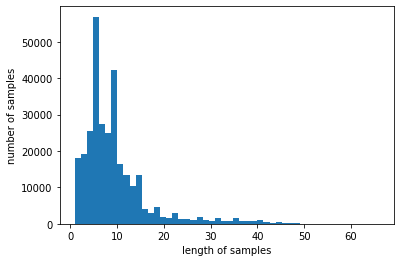

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in x_total))
print('리뷰의 평균 길이 :',sum(map(len, x_total))/len(x_total))
plt.hist([len(review) for review in x_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
# 적절한 샘플 size를 정하기 위한 함수 정의

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [40]:
max_len = 28
below_threshold_len(max_len, x_total)

전체 샘플 중 길이가 28 이하인 샘플의 비율: 96.07159108145002


96%에 해당하는 지점이 길이=28이어서 28로 사이즈를 정함(참고로 30이었을 때는 96.6%였음)

In [47]:
x_total_pad28 = pad_sequences(x_total, maxlen=max_len, padding='post')
# padding = 'post'로 하면 뒤에 0이 붙는다.

In [48]:
print(x_total_pad28[:3])

[[ 166   32   30   79   92    2   16   26    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5740 1056 1699 1402 5848 1068  320  486  789   31  340  585  157   53
  1705 1020    8 5740    3  126    8   24  543 1798 1424  285    3  510]
 [6177   51  354  134 4502   53  127   73    5   46    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [63]:
# 길이 28로 패딩된 배열을 일단 저장
np.save(path + 'x_total_pad28.npy', x_total_pad28)

### 5-3. Word2Vec으로 워드 임베딩 수행  
보통 단어들을 고유한 정수로 맵핑한 후에 각 정수를 고유한 단어 벡터로 바꾸는 작업인 **임베딩(Embedding)**을 수행한다고 함  
단어 벡터를 얻는 방법에 크게 **'원-핫 인코딩'**과 **'워드 임베딩'**이 있는데, '원-핫 인코딩'은 <u>단어 간 상관관계를 파악할 수 없어</u> 주로 '워드 임베딩'이 사용된다고 함  
따라서 '워드 임베딩' 중 가장 많이 쓰이는 **Word2Vec**으로 워드 임베딩 수행

Word2Vec 모델의 파라미터 설명  
- sentences: 임베딩하고자 하는 단어 배열**이 아니라!! Word2Vec은 단어 코퍼스를 넣어야 한다고 함!!(현재 단어 코퍼스는 앞선 단계에서 만든 x_train인듯)**  
위 sentences에 x_total_pad28, x_total을 넣었을 때 모두 error 떴음  
오류 참고 사이트: https://stackoverflow.com/questions/52220514/typeerror-ufunc-add-did-not-contain-a-loop-with-signature-matching-types-dtyp   
- size: Word2Vec 임베딩의 차원 수, 보통 100을 많이 사용
- window: 타깃 단어 앞뒤로 고려할 단어 수
- workers: CPU 스레드(thread) 개수, 보통 4를 많이 사용
- sg: 0이면 CBOW 모델, 1이면 Skip-gram 모델, 즉 어떤 모델로 학습할지를 결정하는 파라미터


In [57]:
x_train

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'],
 ['디자인',
  '배우다',
  '학생',
  '외국',
  '디자이너',
  '그',
  '일군',
  '전통',
  '통해',
  '발전',
  '문화',
  '산업',
  '부럽다',
  '사실',
  '우리나라',
  '에서도',
  '그',
  '어렵다',
  '시절',
  '끝',
  '까지',
  '열정',
  '지키다',
  '노라노',
  '같다',
  '전통',
  '있다',
  '저',
  '같다',
  '사람',
  '꿈',
  '꾸다',
  '이루다',
  '나가다',
  '있다',
  '감사하다'],
 ['폴리스', '스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고'],
 ['오다',
  '연기',
  '진짜',
  '개',
  '쩔다',
  '지루하다',
  '라고',
  '생각',
  '몰입',
  '보다',
  '그렇다',
  '이렇다',
  '진짜',
  '영화',
  '지'],
 ['안개', '자욱하다', '밤하늘', '뜨다', '있다', '초승달', '같다', '영화'],
 ['사랑', '해보다', '사람', '라면', '처음', '부터', '끝', '까지', '웃', '있다', '영화'],
 ['정말', '감동', '다시', '보다', '감동'],
 ['개', '전쟁', '나오다', '나오다', '빠', '보고', '싶다'],
 ['굿'],
 ['바보', '아니다', '병', '쉰', '인', '듯'],
 ['내',
  '나이',
  '같다',
  '영화',
  '지금',
  '보다',
  '나',
  '감동',
  '적',
  '하지만',
  '훗날',
  '다시',
  '보다',
  '대사',
  '하나',
  '하나',
  '그',
  '감정',
  '완벽하다',
  '이해',
  '만',
  '같다'],
 ['재밌다'],
 ['고질', '라니', '무', '귀엽다', 'ㅋㅋ'

Skip-gram이 같은 말뭉치로도 더 많은 학습 데이터를 확보할 수 있어 임베딩 품질이 CBOW보다 좋은 경향이 있다고 함.  
- CBOW: 주변에 있는 문맥 단어(context word)들을 가지고 타깃 단어(target word) 하나를 맞추는 과정에서 학습됨 -> <u>뭔가 BERT의 프리트레인 방식과 비슷한 듯</u>
- Skip-gram: 타깃 단어(target word)를 가지고 주변 문맥 단어(context word)가 무엇일지 예측하는 과정에서 학습됨  
따라서 일단 Skip-gram 방식으로 임베딩 진행함  
*출처: 한국어 임베딩(이기창 지음)*

In [58]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
   level=logging.INFO)

로깅을 할 떄 format을 위와 같이 지정하고, 로그 수준을 INFO로 하면 word2vec의 학습과정에서 로그 메시지를 양식에 맞게 INFO 수준으로 볼 수 있다고 함  
출처:https://devtimes.com/nb-text-classification-word2vec/ 

In [59]:
from gensim.models import Word2Vec

model_sg = Word2Vec(sentences = x_train, size=100, window=2, workers=4, sg=1)

2022-08-03 09:43:31,482 : INFO : collecting all words and their counts
2022-08-03 09:43:31,485 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-03 09:43:31,525 : INFO : PROGRESS: at sentence #10000, processed 102201 words, keeping 10778 word types
2022-08-03 09:43:31,564 : INFO : PROGRESS: at sentence #20000, processed 207966 words, keeping 15187 word types
2022-08-03 09:43:31,600 : INFO : PROGRESS: at sentence #30000, processed 312046 words, keeping 18289 word types
2022-08-03 09:43:31,635 : INFO : PROGRESS: at sentence #40000, processed 416785 words, keeping 20678 word types
2022-08-03 09:43:31,672 : INFO : PROGRESS: at sentence #50000, processed 520597 words, keeping 22759 word types
2022-08-03 09:43:31,710 : INFO : PROGRESS: at sentence #60000, processed 625750 words, keeping 24625 word types
2022-08-03 09:43:31,752 : INFO : PROGRESS: at sentence #70000, processed 736286 words, keeping 26762 word types
2022-08-03 09:43:31,794 : INFO : PROGRESS: at 

In [61]:
# 완성된 Skip-gram 임베딩 매트릭스의 크기 확인
model_sg.wv.vectors.shape

(17432, 100)

총 17,432개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있음

In [62]:
# 최민식과 유사한 단어들을 뽑아보았음
print(model_sg.wv.most_similar("최민식"))

2022-08-03 09:47:27,797 : INFO : precomputing L2-norms of word weight vectors


[('한석규', 0.8504416346549988), ('이민호', 0.844555139541626), ('이정재', 0.8318557739257812), ('안성기', 0.8229949474334717), ('김갑수', 0.8109861016273499), ('윤제문', 0.808348536491394), ('송강호', 0.808249294757843), ('서영희', 0.8070392608642578), ('채시라', 0.8047627210617065), ('설경구', 0.8037620186805725)]


In [65]:
# Skip-gram 모델 저장
model_sg.save('word2vec_sg_model')

2022-08-03 10:08:06,870 : INFO : saving Word2Vec object under word2vec_sg_model, separately None
2022-08-03 10:08:06,875 : INFO : not storing attribute vectors_norm
2022-08-03 10:08:06,878 : INFO : not storing attribute cum_table
2022-08-03 10:08:07,174 : INFO : saved word2vec_sg_model


혹시 모르니 CBOW 방식으로도 모델 만들어 봄

In [66]:
model_cbow = Word2Vec(sentences = x_train, size=100, window=2, workers=4, sg=0)

2022-08-03 10:10:21,579 : INFO : collecting all words and their counts
2022-08-03 10:10:21,584 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-03 10:10:21,625 : INFO : PROGRESS: at sentence #10000, processed 102201 words, keeping 10778 word types
2022-08-03 10:10:21,661 : INFO : PROGRESS: at sentence #20000, processed 207966 words, keeping 15187 word types
2022-08-03 10:10:21,694 : INFO : PROGRESS: at sentence #30000, processed 312046 words, keeping 18289 word types
2022-08-03 10:10:21,729 : INFO : PROGRESS: at sentence #40000, processed 416785 words, keeping 20678 word types
2022-08-03 10:10:21,766 : INFO : PROGRESS: at sentence #50000, processed 520597 words, keeping 22759 word types
2022-08-03 10:10:21,817 : INFO : PROGRESS: at sentence #60000, processed 625750 words, keeping 24625 word types
2022-08-03 10:10:21,862 : INFO : PROGRESS: at sentence #70000, processed 736286 words, keeping 26762 word types
2022-08-03 10:10:21,906 : INFO : PROGRESS: at 

In [67]:
# 완성된 CBOW 임베딩 매트릭스의 크기 확인
model_cbow.wv.vectors.shape

# 매트릭스 크기는 Skip-gram 방식과 동일

(17432, 100)

In [68]:
# 최민식과 유사한 단어들을 뽑아보았음
print(model_cbow.wv.most_similar("최민식"))

2022-08-03 10:12:10,383 : INFO : precomputing L2-norms of word weight vectors


[('한석규', 0.8919599056243896), ('박중훈', 0.8675743341445923), ('엄정화', 0.8562177419662476), ('김창완', 0.8546334505081177), ('서인국', 0.8542219996452332), ('윤제문', 0.8525416254997253), ('김갑수', 0.8521864414215088), ('서영희', 0.8511428833007812), ('안성기', 0.8490802049636841), ('공효진', 0.8469169735908508)]


유사한 단어 출력결과를 보니 Skip-gram과 CBOW에서 서로 다른 결과가 나옴. 유사하다고 판단한 단어도 다르고, 유사하다고 판단한 정도(%)도 달랐음  
이건 추후에 둘 중 더 좋은 것을 하나 택하는 것도 나쁘지 않을듯

In [69]:
# CBOW 모델 저장
model_cbow.save('word2vec_cbow_model')

2022-08-03 10:15:21,592 : INFO : saving Word2Vec object under word2vec_cbow_model, separately None
2022-08-03 10:15:21,597 : INFO : not storing attribute vectors_norm
2022-08-03 10:15:21,600 : INFO : not storing attribute cum_table
2022-08-03 10:15:21,810 : INFO : saved word2vec_cbow_model


뭔가 5-2까지해서 만든 길이 28의 배열과 5-3의 Word2Vec 임베딩이 이어지지 않아서 내가 뭔가를 잘못한 것 같은 느낌이 듦...